import sys
from pathlib import Path

import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import json
import re
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

import sys
from pathlib import Path

import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import json
import re
import pandas as pd


import nltk

# Download the VADER lexicon (for sentiment)
nltk.download("vader_lexicon")

In [7]:
TWEETS_DIR = Path("..") / "data" / "tweets"
REGIONS = ["nyc", "sg", "uk"]

def clean_text(text: str) -> str:
    """
    Shared cleaner for all later analysis:
    - lowercase
    - remove URLs, @handles, and #hashtags
    - keep only letters and spaces
    - collapse multiple spaces
    """
    if not text:
        return ""
    text = text.lower()
    text = re.sub(r"http\S+", " ", text)        # URLs
    text = re.sub(r"[@#]\S+", " ", text)        # @handles and #hashtags
    text = re.sub(r"[^a-z\s]", " ", text)       # non-letters
    text = re.sub(r'&amp;', ' ', text)     # Replaces '&amp;' with a space
    text = re.sub(r"\s+", " ", text).strip()
    return text

def load_region_tweets(region: str) -> list[dict]:
    """
    Load all tweets for a given region from the external JSONL file and
    return a list of rows with region + raw/cleaned text.
    """
    path = TWEETS_DIR / f"{region}_tweets_external.jsonl"
    rows: list[dict] = []

    with path.open() as f:
        for line in f:
            obj = json.loads(line)
            raw = obj.get("text") or obj.get("tweet_text") or ""
            clean = clean_text(raw)
            # skip very short tweets (mostly noise)
            if len(clean.split()) < 5:
                continue

            rows.append({
                "region": region,
                "tweet_id": obj.get("id"),
                "author_id": obj.get("author_id"),
                "text_raw": raw,
                "text_clean": clean,
            })

    print(f"{region.upper()}: loaded {len(rows)} cleaned tweets")
    return rows

all_rows: list[dict] = []
for r in REGIONS:
    all_rows.extend(load_region_tweets(r))

tweets_df = pd.DataFrame(all_rows)

print("\nTweets per region (after cleaning):")
display(tweets_df.groupby("region")["text_clean"].count())

NYC: loaded 1262 cleaned tweets
SG: loaded 1632 cleaned tweets
UK: loaded 2049 cleaned tweets

Tweets per region (after cleaning):


region
nyc    1262
sg     1632
uk     2049
Name: text_clean, dtype: int64

# Step 2: Two ways to read “culture” from tweets

# 2.A: Sentiment view with VADER

Small paragraph:

VADER is a sentiment lexicon and rule system for social media.

Outputs neg, neu, pos, compound for each tweet.

## 2.A.1 Apply VADER to NYC SG UK + Graph

In [10]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def add_vader_scores(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add NLTK VADER sentiment scores (neg, neu, pos, compound)
    for each tweet in `text_clean`.
    """
    scores = df["text_clean"].apply(sia.polarity_scores)  # returns dict per row
    scores_df = pd.DataFrame(scores.tolist())
    return pd.concat([df.reset_index(drop=True), scores_df], axis=1)

def vader_by_region(df_with_scores: pd.DataFrame) -> pd.DataFrame:
    """
    Average VADER scores per region.
    """
    return (
        df_with_scores
        .groupby("region")[["neg", "neu", "pos", "compound"]]
        .mean()
        .sort_index()
    )

# Apply to our tweets_df from Step 2.1
tweets_with_vader = add_vader_scores(tweets_df)
vader_region = vader_by_region(tweets_with_vader)

print("Average VADER sentiment per region:")
display(vader_region)


Average VADER sentiment per region:


,neg,neu,pos,compound
region,,,,
nyc,0.087015,0.792139,0.120845,0.098598
sg,0.054817,0.832182,0.113000,0.166831
uk,0.067219,0.815514,0.117263,0.141746


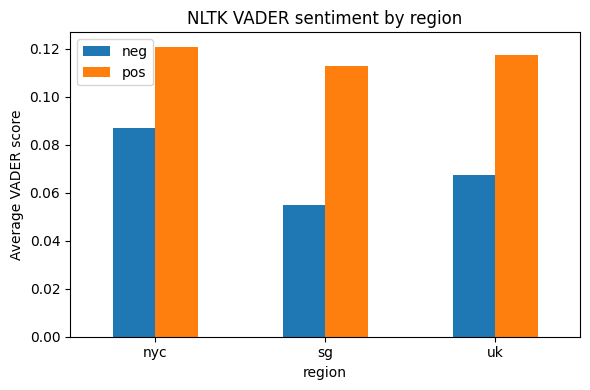

In [11]:
ax = vader_region[["neg", "pos"]].plot(kind="bar", figsize=(6, 4))
ax.set_ylabel("Average VADER score")
ax.set_title("NLTK VADER sentiment by region")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 2.A.3 VADER conclusion

Short paragraph under the plot:

NYC shows more emotional intensity (higher neg and pos on average).

SG has the highest average compound score, so tweets skew more positive.

UK sits between, closer to SG on positivity than to NYC.

Caveat: sentiment tells you “mood” but not “topic.”

Transition sentence:

“So sentiment gives us a first pass on mood. To understand what people in each region actually talk about, we need a dictionary over topics and personality, not just positive or negative words.”

# 2.B Dictionary view of culture

This is your six-category example. You already have the code and two charts.

Markdown intro:

Explain that this is a baby version of a dictionary method.

Six handcrafted categories: self, social, work, money, positive, negative.

Show how you go from tweets → counts → words per 100 words.

Under the plots, a short conclusion:

Raw per 100 words: NYC is “louder” in almost every category.

Relative percentages: all three are dominated by self and social, SG leans more on work and money, UK slightly more positive.

This is just a teaching demo so the reader can see the mechanics before you switch to a real dictionary.

Transition sentence:

“This tiny dictionary is not enough for real analysis, but it shows the pipeline. Next I swap it for a real library that has almost two hundred categories.”

Explain what Empath is.

Use a small interpretable subset (work, money, family, friends, politics, etc).

Plot average scores by region.

# 2.B.1 Empath setup and small subset

In [14]:
# Step 2.A.1 – Empath setup (topic/personality dictionary)
# official git https://github.com/Ejhfast/empath-client

from empath import Empath

lexicon = Empath()

# Small subset of Empath categories for 2.A (interpretable, not overwhelming)
empath_categories_small = [
    "work",
    "money",
    "family",
    "friends",
    "health",
    "politics",
    "violence",
]

print(f"Using {len(empath_categories_small)} Empath categories:", empath_categories_small)


Using 7 Empath categories: ['work', 'money', 'family', 'friends', 'health', 'politics', 'violence']


In [15]:
from tqdm import tqdm
tqdm.pandas()

def add_empath_features(df: pd.DataFrame, categories: list[str]) -> pd.DataFrame:
    """
    Add Empath features for each tweet in `text_clean`.
    normalize=True → each score ~ fraction of text belonging to that category.
    """
    feats = df["text_clean"].progress_apply(
        lambda txt: lexicon.analyze(txt, categories=categories, normalize=True)
    )
    feats_df = pd.DataFrame(feats.to_list())
    return pd.concat([df.reset_index(drop=True), feats_df], axis=1)

def empath_by_region(df_with_feats: pd.DataFrame, categories: list[str]) -> pd.DataFrame:
    """
    Average Empath category scores per region.
    """
    return (
        df_with_feats
        .groupby("region")[categories]
        .mean()
        .sort_index()
    )


# Apply to tweets_df
tweets_with_empath_small = add_empath_features(tweets_df, empath_categories_small)
empath_region_small = empath_by_region(tweets_with_empath_small, empath_categories_small)

print("Average Empath (small subset) scores per region:")
display(empath_region_small.round(4))


100%|████████████████████████████████████████| 4943/4943 [00:00<00:00, 16813.45it/s]

Average Empath (small subset) scores per region:


,work,money,family,friends,health,politics,violence
region,,,,,,,
nyc,0.0050,0.0045,0.0043,0.0056,0.0019,0.0054,0.0037
sg,0.0064,0.0170,0.0030,0.0027,0.0019,0.0029,0.0029
uk,0.0046,0.0062,0.0047,0.0054,0.0043,0.0019,0.0074


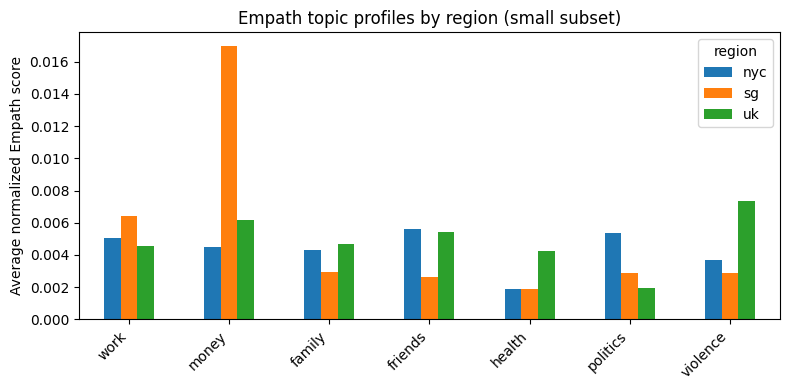

In [16]:
ax = empath_region_small.T.plot(kind="bar", figsize=(8, 4))
ax.set_ylabel("Average normalized Empath score")
ax.set_title("Empath topic profiles by region (small subset)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Short conclusion here:

NYC has a mix of social, politics, and leisure words.

SG already shows a stronger work and money signal.

UK leans a bit toward travel or nightlife categories when those are present.

## 2.B.3 Empath Extended

In [18]:
from tqdm import tqdm
tqdm.pandas()

def add_empath_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add Empath features for each tweet in `text_clean`.
    normalize=True → each score ~ fraction of text belonging to that category.
    """
    feats = df["text_clean"].progress_apply(
        lambda txt: lexicon.analyze(txt, normalize=True)
    )
    feats_df = pd.DataFrame(feats.to_list())
    return pd.concat([df.reset_index(drop=True), feats_df], axis=1)

def empath_by_region(df_with_feats: pd.DataFrame) -> pd.DataFrame:
    """
    Average Empath category scores per region.
    Only keep numeric columns when computing the mean.
    """
    # keep only numeric columns (all empath features + any numeric metadata)
    num_cols = df_with_feats.select_dtypes(include="number").columns

    return (
        df_with_feats
        .groupby("region")[num_cols]
        .mean()
        .sort_index()
    )

# Apply to tweets_df
tweets_with_empath = add_empath_features(tweets_df)

# NOTE: use tweets_with_empath (not tweets_with_empath_small)
empath_region = empath_by_region(tweets_with_empath)

print("Average Empath scores per region:")
display(empath_region.round(4))


100%|██████████████████████████████████████████| 4943/4943 [00:14<00:00, 334.39it/s]


Average Empath scores per region:


,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
region,,,,,,,,,,,,,,,,,,,,,
nyc,0.0025,0.0033,0.0016,0.0045,0.0036,0.0039,0.0028,0.0019,0.0019,0.0029,...,0.0018,0.0056,0.0008,0.0015,0.0066,0.0009,0.0033,0.0024,0.0079,0.0067
sg,0.0033,0.0035,0.0018,0.0170,0.0035,0.0024,0.0013,0.0013,0.0015,0.0011,...,0.0017,0.0020,0.0007,0.0027,0.0053,0.0008,0.0045,0.0029,0.0047,0.0031
uk,0.0017,0.0023,0.0059,0.0062,0.0038,0.0018,0.0041,0.0046,0.0012,0.0015,...,0.0016,0.0036,0.0007,0.0019,0.0047,0.0009,0.0048,0.0058,0.0058,0.0086


In [19]:
# Empath region matrix: rows = [nyc, sg, uk], columns = empath categories
empath_region.shape, empath_region.index, empath_region.columns[:5]


((3, 194),
 Index(['nyc', 'sg', 'uk'], dtype='object', name='region'),
 Index(['help', 'office', 'dance', 'money', 'wedding'], dtype='object'))

In [20]:
TOP_N = 15

for region in empath_region.index:
    print(f"\nTop {TOP_N} Empath categories for {region.upper()}:")
    top = empath_region.loc[region].sort_values(ascending=False).head(TOP_N)
    display(top.to_frame(name="avg_score").round(4))



Top 15 Empath categories for NYC:


,avg_score
play,0.0100
negative_emotion,0.0099
messaging,0.0084
positive_emotion,0.0079
social_media,0.0075
party,0.0069
business,0.0068
government,0.0067
musical,0.0067
giving,0.0066



Top 15 Empath categories for SG:


,avg_score
economics,0.0233
money,0.0170
business,0.0159
payment,0.0131
valuable,0.0121
shopping,0.0117
real_estate,0.0111
banking,0.0111
government,0.0098
internet,0.0092



Top 15 Empath categories for UK:


,avg_score
vacation,0.0125
traveling,0.0100
music,0.0091
party,0.0087
musical,0.0086
celebration,0.0082
vehicle,0.0082
driving,0.0079
social_media,0.0077
business,0.0075


In [27]:
def graph_top_region(region, TOP_N=15):
    top_region = empath_region.loc[region].sort_values(ascending=False).head(TOP_N)
    
    ax = top_region.plot(kind="barh", figsize=(6, 5))
    ax.invert_yaxis()
    ax.set_xlabel("Average normalized Empath score")
    ax.set_title(f"Top {TOP_N} Empath categories – {region.upper()}")
    plt.tight_layout()
    plt.show()

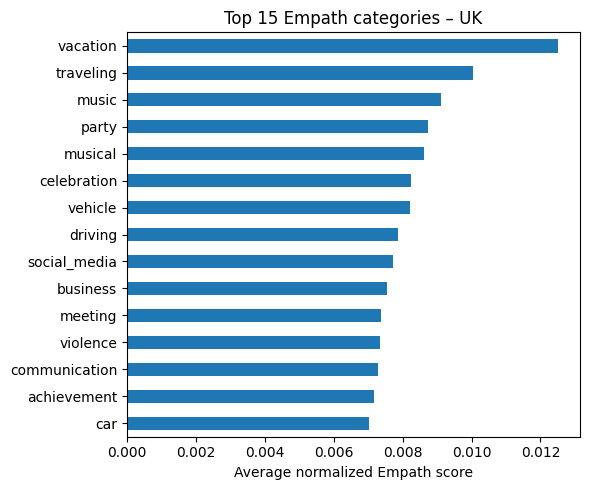

In [28]:
graph_top_region("uk")

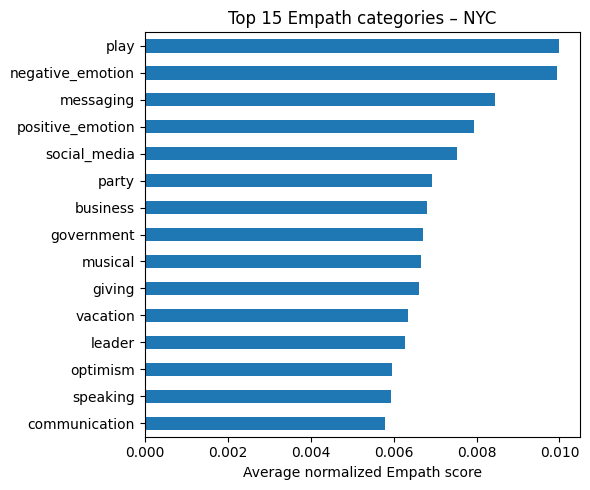

In [29]:
graph_top_region("nyc")

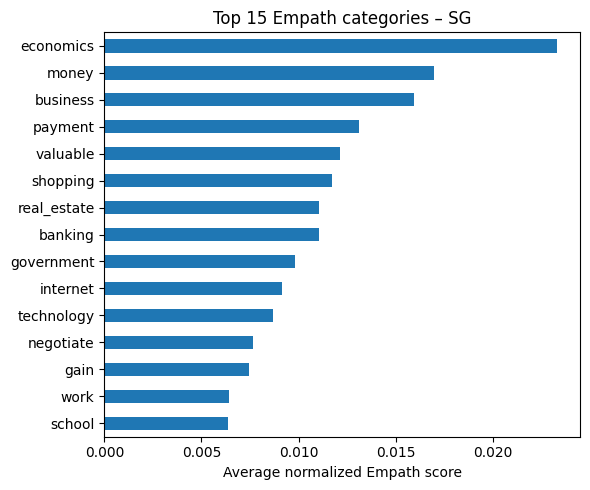

In [30]:
graph_top_region("sg")

In [31]:
# Max difference across regions for each category
diff = (empath_region.max(axis=0) - empath_region.min(axis=0))
top_diff = diff.sort_values(ascending=False).head(20)

print("Categories where regions differ the most:")
display(top_diff.to_frame(name="max_diff").round(4))


Categories where regions differ the most:


,max_diff
economics,0.0191
money,0.0125
payment,0.0105
shopping,0.0095
valuable,0.0094
business,0.0091
banking,0.0085
play,0.0075
negotiate,0.0073
vacation,0.0071


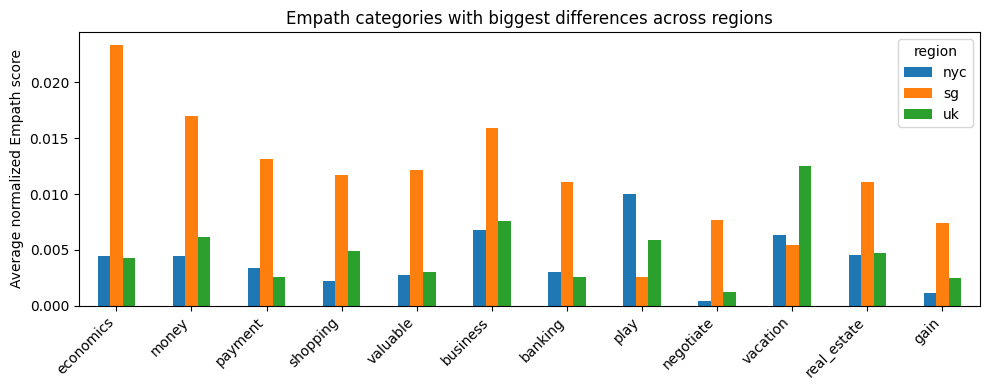

In [32]:
TOP_K = 12
diff_cats = top_diff.index[:TOP_K]

subset = empath_region[diff_cats]

ax = subset.T.plot(kind="bar", figsize=(10, 4))
ax.set_ylabel("Average normalized Empath score")
ax.set_title("Empath categories with biggest differences across regions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 2.B.3 PCA + UMAP on Empath Features

In [33]:
# Numeric empath columns (exclude id/text/etc.)
empath_cols = tweets_with_empath.select_dtypes(include="number").columns

X = tweets_with_empath[empath_cols].values
y = tweets_with_empath["region"].values


Explained variance: [0.03314976 0.02874146]


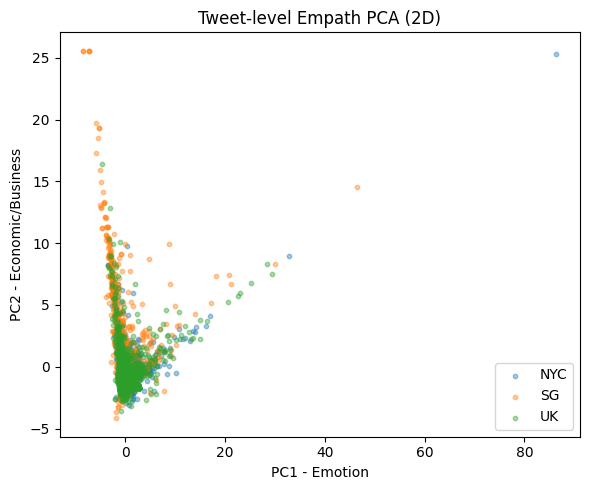

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame({
    "PC1 - Emotion": X_pca[:, 0],
    "PC2 - Economic/Business": X_pca[:, 1],
    "region": y,
})

print("Explained variance:", pca.explained_variance_ratio_)

plt.figure(figsize=(6, 5))
for region in pca_df["region"].unique():
    mask = pca_df["region"] == region
    plt.scatter(
        pca_df.loc[mask, "PC1 - Emotion"],
        pca_df.loc[mask, "PC2 - Economic/Business"],
        label=region.upper(),
        alpha=0.4,
        s=10,
    )

plt.xlabel("PC1 - Emotion")
plt.ylabel("PC2 - Economic/Business")
plt.title("Tweet-level Empath PCA (2D)")
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
loadings = pd.DataFrame(
    pca.components_,
    columns=empath_cols,
    index=["PC1", "PC2"]
)

for pc in ["PC1", "PC2"]:
    print(f"\nTop 15 loadings for {pc}:")
    top = loadings.loc[pc].sort_values(key=abs, ascending=False).head(15)
    display(top.to_frame(name="loading").round(3))



Top 15 loadings for PC1:


,loading
sadness,0.283
nervousness,0.268
joy,0.267
contentment,0.256
zest,0.254
fear,0.243
sympathy,0.238
shame,0.226
suffering,0.193
lust,0.183



Top 15 loadings for PC2:


,loading
economics,0.337
money,0.328
payment,0.319
valuable,0.308
banking,0.300
negotiate,0.274
real_estate,0.236
wealthy,0.223
gain,0.208
business,0.195
